In [4]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [7]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from models.models_new import Renorm_Dynamic
from dynamic_models_sis_new import Simple_Spring_Model
from models_new import VAE
from train import train_vae
from ei.EI_calculation import test_vae_causal_multi_sis

from datetime import datetime
t0 = datetime.now()
spring = Simple_Spring_Model(device=device)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [3]:
# whole sample
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 1
interval = 1
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10*interval, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt,interval=interval) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps*interval, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt,interval=interval)

# Train

In [ ]:
sz = 4
scale = 2
mae2_w = 3
T_total = 30001

eis_vae, term1s_vae, term2s_vae, losses_vae, MAEs_mstep_vae, vae = train_vae(train_data=train_data, test_data=test_data, 
                                                            sz=sz, scale=scale, mae2_w=mae2_w, T2=T_total,  sigma=0.03, rou=-0.5, dt=dt, 
                                                                             L=1, hidden_units = 64, batch_size = 700)

# Five parallel experiments

In [ ]:
# whole sample
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 1
interval = 1

sz = 4
scale = 2
mae2_w = 3
T_total = 30001
experiments = 5
MAEs_mstep_e = np.zeros([experiments, T_total//500+1])
eis_e = np.zeros([experiments, T_total//500+1])


for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10*interval, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt,interval=interval) 
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps*interval, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt,interval=interval)
    eis_vae, term1s_vae, term2s_vae, losses_vae, MAEs_mstep_vae, vae = train_vae(train_data=train_data, test_data=test_data, 
                                                            sz=sz, scale=scale, mae2_w=mae2_w, T2=T_total,  sigma=0.03, rou=-0.5, dt=dt, 
                                                                             L=1, hidden_units = 64, batch_size = 700)
    MAEs_mstep_e[e,:] = MAEs_mstep_vae
    eis_e[e,:] = eis_vae

np.save('results/MAEs_mstep_e.npy', MAEs_mstep_e)
np.save('results/eis_e.npy', eis_e)

check point-------o_0-> 18:20:40.863763; lasting 0:00:41.668947 seconds
Epoch: 0
Train loss: 0.3949
dEI: 0.5566
term1: -0.3990
term2: 1.5121
Test multistep loss: 0.4480
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 18:20:51.422118; lasting 0:00:10.558355 seconds
check point-------o_0-> 18:20:54.932755; lasting 0:00:03.510637 seconds
Epoch: 500
Train loss: 0.0669
dEI: 0.0000
term1: -2.9074
term2: 1.8512
Test multistep loss: 0.0578
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 18:20:59.891157; lasting 0:00:04.958402 seconds
check point-------o_0-> 18:21:04.537122; lasting 0:00:04.645965 seconds
Epoch: 1000
Train loss: 0.0626
dEI: 0.0000
term1: -3.3434
term2: 1.9988
Test multistep loss: 0.0610
------------------------------------------------------------------------------------------------------

In [ ]:
# part sample
mul_batch_size = [0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 1
interval = 1

sz = 4
scale = 2
mae2_w = 3
T_total = 30001
experiments = 5
MAEs_mstep_part_e = np.zeros([experiments, T_total//500+1])
eis_part_e = np.zeros([experiments, T_total//500+1])
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10*interval, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt,interval=interval) 
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps*interval, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt,interval=interval)
    eis_vae, term1s_vae, term2s_vae, losses_vae, MAEs_mstep_vae, vae = train_vae(train_data=train_data, test_data=test_data, 
                                                            sz=sz, scale=scale, mae2_w=mae2_w, T2=T_total,  sigma=0.03, rou=-0.5, dt=dt, 
                                                                             L=1, hidden_units = 64, batch_size = 700)
    MAEs_mstep_part_e[e,:] = MAEs_mstep_vae
    eis_part_e[e,:] = eis_vae

np.save('results/MAEs_mstep_part_e.npy', MAEs_mstep_part_e)
np.save('results/eis_part_e.npy', eis_part_e)

# Plot

In [13]:
MAEs_mstep_e = np.load('results/MAEs_mstep_e.npy')
eis_e = np.load('results/eis_e.npy')
MAEs_mstep_part_e = np.load('results/MAEs_mstep_part_e.npy')
eis_part_e = np.load('results/eis_part_e.npy')

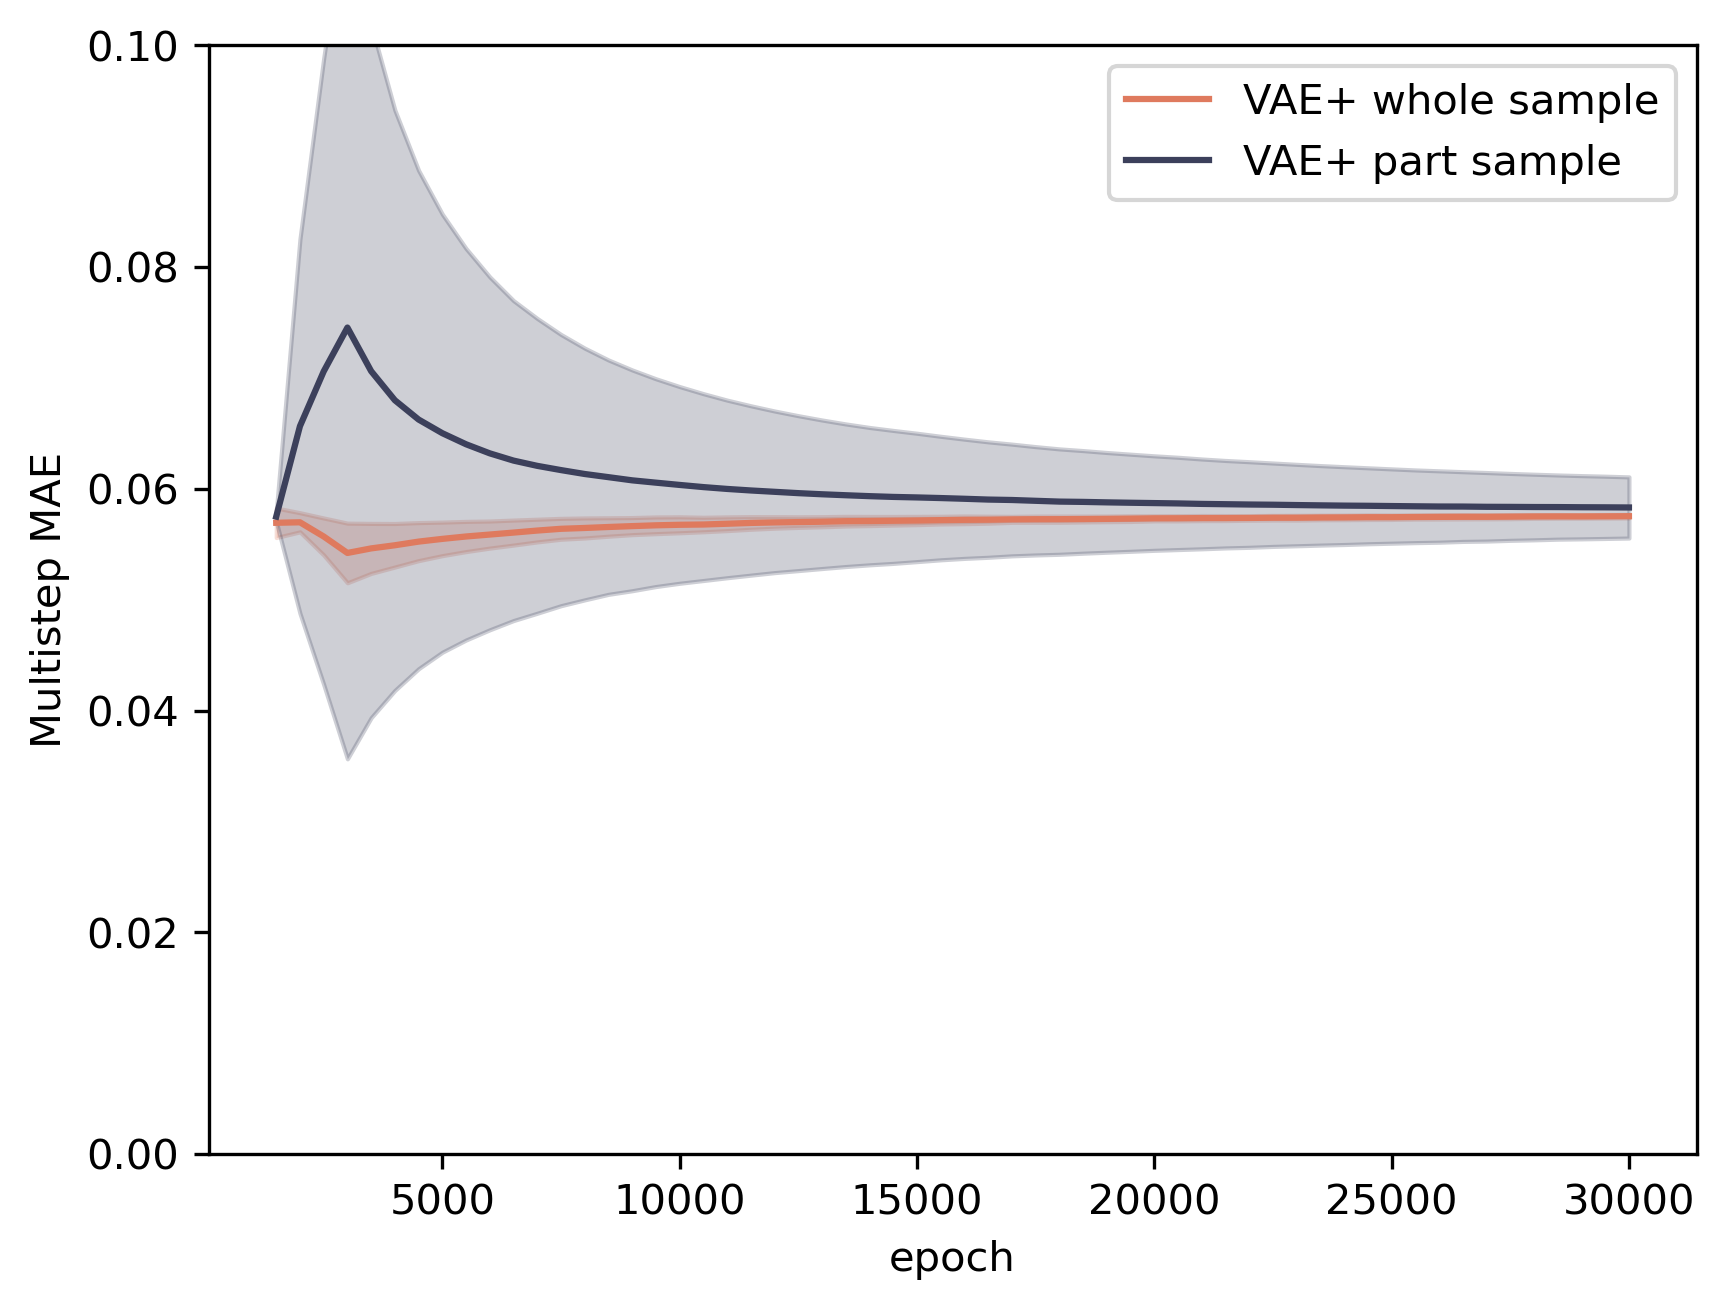

In [14]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
lens=len(MAEs_mstep_e[0,3:])
timesteps = np.arange(len(MAEs_mstep_e[0,:]))[3:]*500
compare1=np.cumsum(MAEs_mstep_e[:,3:],1)/np.linspace(1, lens, lens)
compare2=np.cumsum(MAEs_mstep_part_e[:,3:],1)/np.linspace(1, lens, lens)
means_nis = np.mean(compare1,axis=0)
stds_nis = np.std(compare1,axis=0)
means_nisp = np.mean(compare2,axis=0)
stds_nisp = np.std(compare2,axis=0)
plt.plot(timesteps, means_nis, label='VAE+ whole sample',color=color_label[1])
plt.fill_between(timesteps, means_nis-stds_nis, means_nis+stds_nis,alpha=0.25,color=color_label[1])
plt.plot(timesteps, means_nisp, label='VAE+ part sample',color=color_label[2])
plt.fill_between(timesteps, means_nisp-stds_nisp, means_nisp+stds_nisp,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel('Multistep MAE')
plt.ylim([0,0.1])
plt.show()

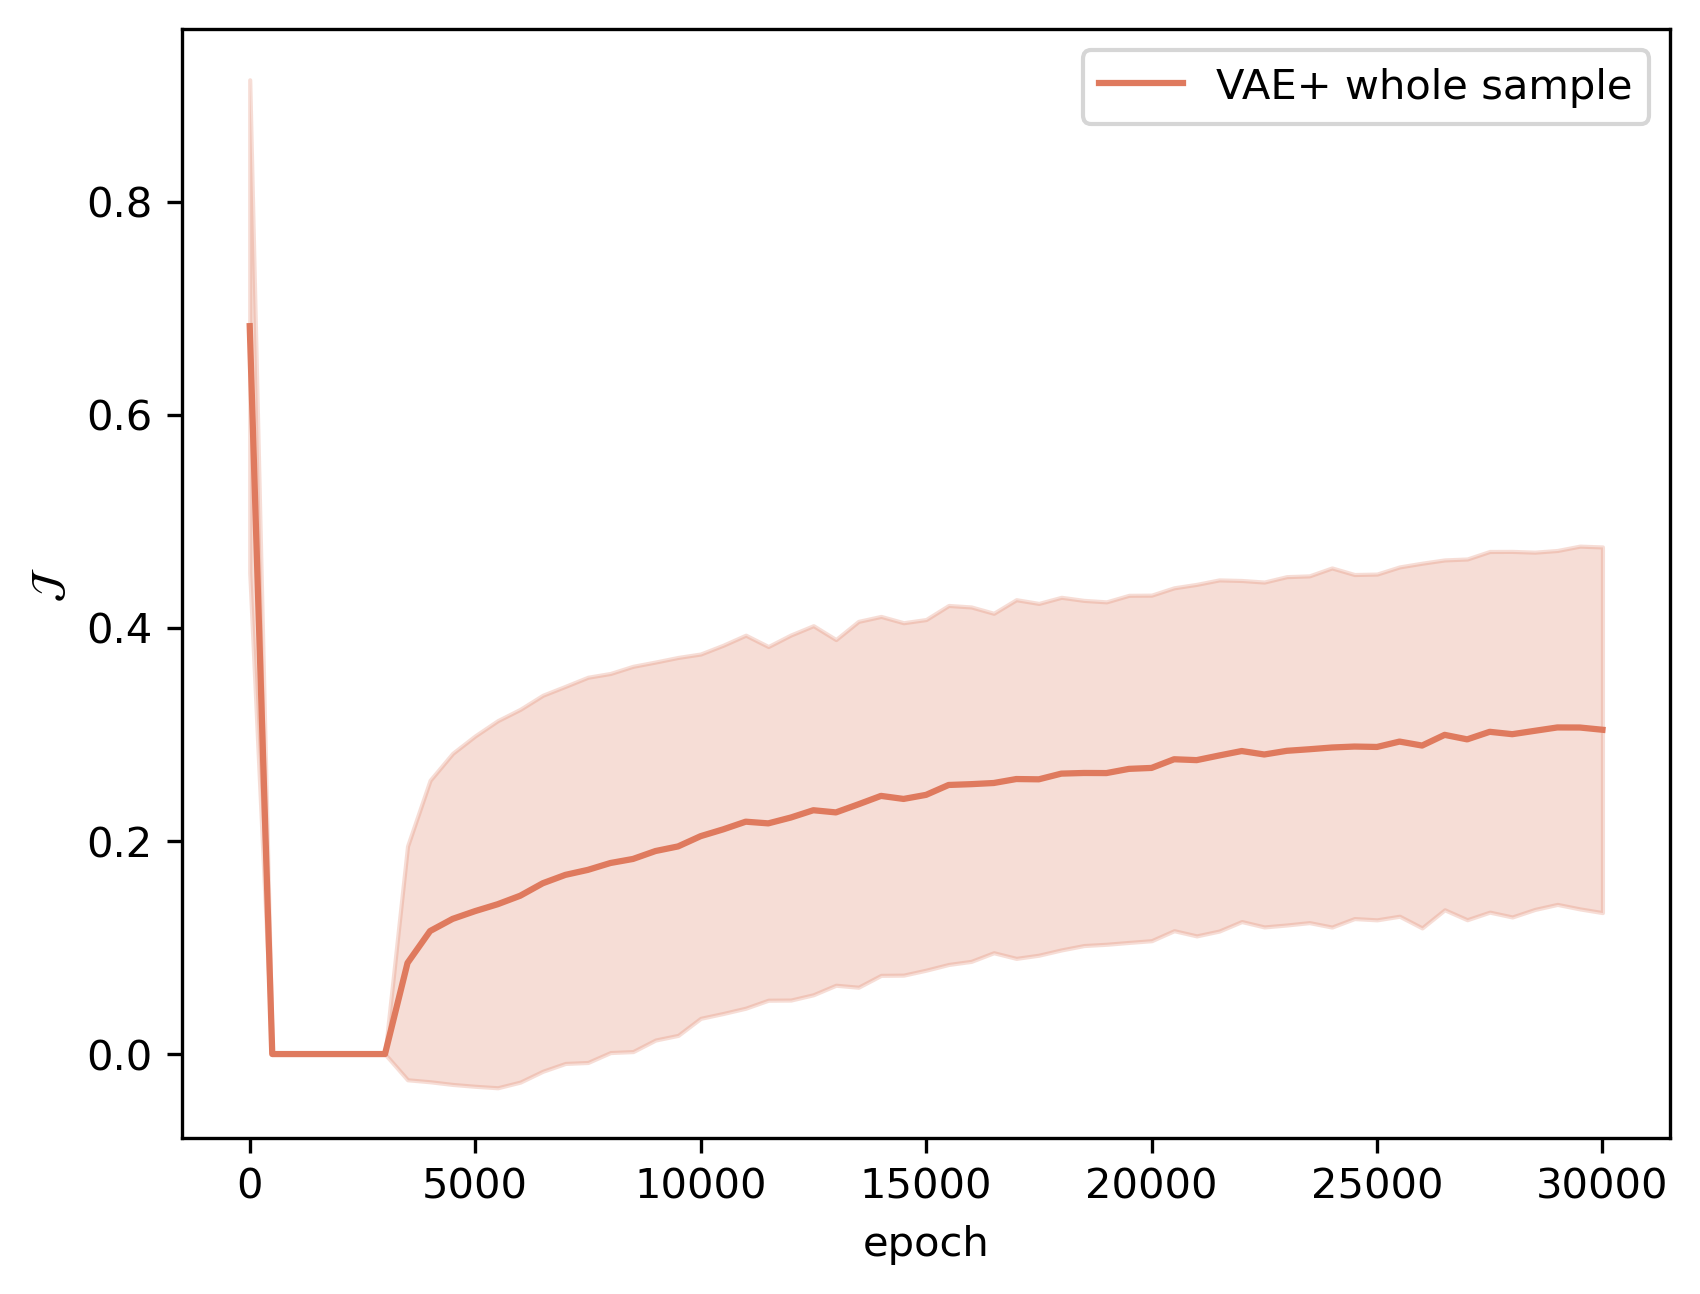

In [18]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
timesteps = np.arange(len(eis_vae))*500
means_whole = np.mean(eis_e,axis=0)
stds_whole = np.std(eis_e,axis=0)
means_part = np.mean(eis_part_e,axis=0)
stds_part = np.std(eis_part_e,axis=0)
plt.plot(timesteps, means_whole, label='VAE+ whole sample',color=color_label[1])
plt.fill_between(timesteps, means_whole-stds_whole, means_whole+stds_whole,alpha=0.25,color=color_label[1])
# plt.plot(timesteps, means_part, label='VAE+ part sample',color=color_label[2])
# plt.fill_between(timesteps, means_part-stds_part, means_part+stds_part,alpha=0.25,color=color_label[2])
plt.legend()
plt.xlabel("epoch")
plt.ylabel(r'$\mathcal{J}$')
plt.show()